### 1. Import packages and scripts

In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wntr
import random
import time
import pickle
from pipedream_kalman_filter import apply_EKF
import viswaternet as vis
from matplotlib.lines import Line2D
#Don't show future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 2. Read INP file and specify estimation nodes and holdout nodes

In [2]:
%matplotlib inline

In [3]:
inp = 'new_ky6'
inp_path = f'./Networks/{inp}.inp'

In [4]:
wn = wntr.network.WaterNetworkModel(inp_path)

C:\Software\Anaconda\lib\site-packages\wntr\epanet\io.py:2075: UserWarning: Not all curves were used in "./Networks/new_ky6.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [5]:
# Define list of boundary nodes
boundary_nodes = []

# Nodes upstream and downstream of valves and pumps
for _, valve in wn.valves():
    boundary_nodes.append(valve.start_node_name)
    boundary_nodes.append(valve.end_node_name)
for _, pump in wn.pumps():
    boundary_nodes.append(pump.start_node_name)
    boundary_nodes.append(pump.end_node_name)

# Reservoirs and tanks    
for reservoir in wn.reservoir_name_list:
    boundary_nodes.append(reservoir)
for tank in wn.tank_name_list:
    boundary_nodes.append(tank)

In [6]:
# Define list of junctions in network where sensors are placed
sensor_nodes = ['J-338', 'J-12',  'J-5', 'J-204']

In [7]:
# Estimation nodes: list of boundary nodes + junctions with sensors
estimation_nodes = sensor_nodes + boundary_nodes  

m = len(estimation_nodes)

In [8]:
# Holdout nodes
holdout_nodes = ['J-86', 'J-404', 'J-111', 'J-135']

### 3. Set up and run SE problem and extract results

In [9]:
dt = 3600 # simulation time step [s]
t_run = 24 # simulation duration [hrs]

n = wn.num_nodes + wn.num_tanks # number of junctions in pipedream model. Extra junctions added to turn on/ off tank access

sensor_std_dev = 0.25 
Rcov = (0.5**2) * np.eye(m) # uncertainty for state equation
Qcov = (0.5**2) * np.eye(n) # uncertainty for observation equation

In [10]:
H_df_filtered, H_df_real, H_df_model, H_df_sensor, model, Q_pump_model, Q_pump_ekf, Q_prv_model, Q_prv_ekf, measurements, Q_df_model, Q_df_filtered = apply_EKF(inp_path, estimation_nodes, t_run=t_run, dt=dt,
                                                               banded=False, Rcov=Rcov, Qcov=Qcov, 
                                                               sensor_std_dev=sensor_std_dev, num_iter=40)

C:\Software\Anaconda\lib\site-packages\wntr\epanet\io.py:2075: UserWarning: Not all curves were used in "./Networks/new_ky6.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\mst2245\Box Sync\Research\OCSENet paper\Github\approach 2\pipedream_solver\nsuperlink.py:1293: LinAlgWarning: Ill-conditioned matrix (rcond=8.28744e-17): result may not be accurate.
  H_j_next = scipy.linalg.solve(l, r)


### 4. Read in sensor measurements and real pressure heads from decalibrated model

In [11]:
H_df_sensor = pd.read_csv('Networks/ky6_data/ky6_measurements.csv', index_col=0)
H_df_real = pd.read_csv('Networks/ky6_data/ky6_real.csv', index_col=0)

### 5. Compare time series for measurements, model predictions, EKF estimates, and real pressure heads (Fig S2 in the SI)

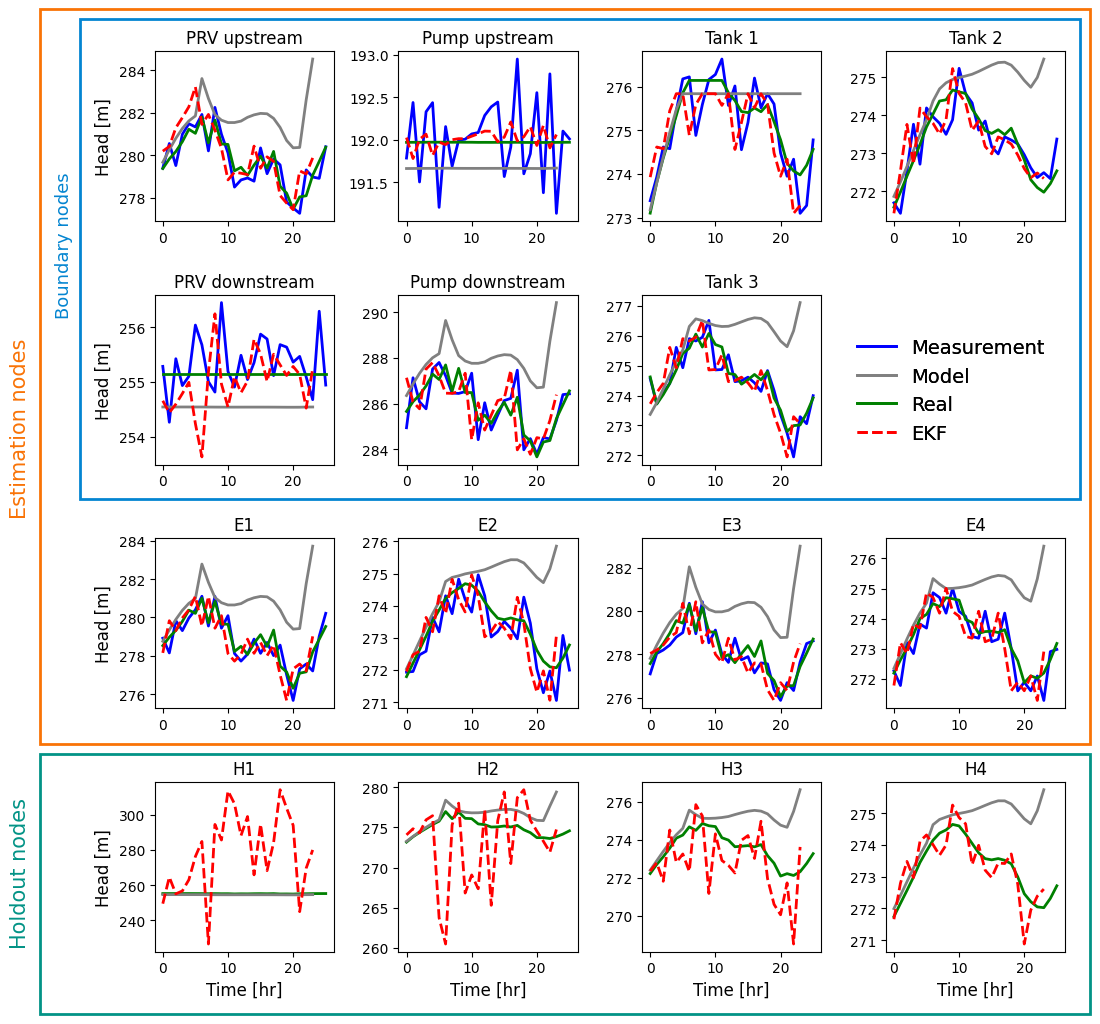

In [12]:
# Note PRV start and end nodes
prv_start, prv_end, pump_start, pump_end = [], [], [], []
for _, valve in wn.valves():
    prv_start.append(valve.start_node_name)
    prv_end.append(valve.end_node_name)
for _, pump in wn.pumps():
    pump_start.append(pump.start_node_name)
    pump_end.append(pump.end_node_name)
    
# Re-order boundary nodes for clear plotting
critical_titles = wn.tank_name_list + prv_start + prv_end + pump_start + pump_end
critical_sensors_list = prv_start + pump_start + ['T-1', 'T-2']+ prv_end + pump_end + ['T-3']
critical_titles = ['PRV upstream', 'Pump upstream', 'Tank 1', 'Tank 2', 'PRV downstream', 'Pump downstream', 'Tank 3']
n_cols = 4
n_rows = int(np.ceil((len(sensor_nodes )/ n_cols))) + int(np.ceil((len(critical_titles )/ n_cols))) + int(np.ceil((len(holdout_nodes)/ n_cols)))
if n_rows==0:
    n_rows = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,  10 * n_rows / n_cols))
    

for index, name in enumerate(critical_sensors_list) :
    row = int(index//n_cols)
    col = index%n_cols
    if name in estimation_nodes:
        ax[row][col].plot(H_df_sensor[name].index / 3600, H_df_sensor[name].values, c='b', linewidth=2, label='Measurement')
    ax[row][col].plot(H_df_real[name].index / 3600, H_df_real[name].values, c='g', linewidth=2, label='Real')
    ax[row][col].set_title(critical_titles[index], size=12)    
    ax[row][col].plot(H_df_model[name].index / 3600, H_df_model[name].values, c='gray',linewidth=2, label='Model')
    ax[row][col].plot(H_df_filtered[name].index / 3600, H_df_filtered[name].values,  c='r', linestyle = '--', linewidth=2, label='EKF')
    if col == 0:
        ax[row][col].set_ylabel('Head [m]', size=12)
    
for index, name in enumerate(sensor_nodes) :
    row = int(np.ceil((len(critical_sensors_list )/ n_cols))) + int(index//n_cols)
    col = index%n_cols
    if name in estimation_nodes:
        ax[row][col].plot(H_df_sensor[name].index / 3600, H_df_sensor[name].values, c='b', linewidth=2, label='Measurement')
    ax[row][col].plot(H_df_real[name].index / 3600, H_df_real[name].values, c='g', linewidth=2, label='Real')
    ax[row][col].set_title(f'E{col+1}', size=12)    
    ax[row][col].plot(H_df_model[name].index / 3600, H_df_model[name].values, c='gray',linewidth=2, label='Model')
    ax[row][col].plot(H_df_filtered[name].index / 3600, H_df_filtered[name].values,  c='r', linestyle = '--', linewidth=2, label='EKF')
    if col == 0:
        ax[row][col].set_ylabel('Head [m]', size=12)
    
for index, name in enumerate(holdout_nodes) :
    row = int(np.ceil((len(critical_sensors_list )/ n_cols))) + int(np.ceil((len(sensor_nodes )/ n_cols))) + int(index//n_cols)
    col = index%n_cols
    if name in estimation_nodes:
        ax[row][col].plot(H_df_sensor[name].index / 3600, H_df_sensor[name].values, c='b', linewidth=2, label='Measurement')
    ax[row][col].plot(H_df_real[name].index / 3600, H_df_real[name].values, c='g', linewidth=2, label='Real')
    ax[row][col].set_title(f'H{col+1}', size=12)    
    ax[row][col].plot(H_df_model[name].index / 3600, H_df_model[name].values, c='gray',linewidth=2, label='Model')
    ax[row][col].plot(H_df_filtered[name].index / 3600, H_df_filtered[name].values,  c='r', linestyle = '--', linewidth=2, label='EKF')
    if col == 0:
        ax[row][col].set_ylabel('Head [m]', size=12)
    if row == n_rows -1 :
        ax[row][col].set_xlabel('Time [hr]', size=12)
    if row == n_rows - 2 and col > 1:
        ax[row][col].set_xlabel('Time [hr]', size=12)


ax[1][3].set_visible(False)

# Build legend
custom_lines2 = [Line2D([0], [0], color='b', lw=2),
                 Line2D([0], [0], color='gray',  lw=2),
                Line2D([0], [0], color='g', lw=2),
                Line2D([0], [0], color='r', lw=2, linestyle = '--')]
leg_labels2 = ['Measurement', 'Model', 'Real', 'EKF']

legend2 = ax[1][2].legend(custom_lines2, leg_labels2, 
                    fontsize='14', frameon=False, bbox_to_anchor=(1.1, 0.85))
ax[1][2].add_artist(legend2)

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.00, 0.515), 1.00, 0.48, fill=False, color="xkcd:cerulean", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (-0.04, 0.27), 1.05, 0.735, fill=False, color="xkcd:orange", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (-0.04, 0.0), 1.05, 0.26, fill=False, color="xkcd:teal", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

#Adjust the subplot parameters to add white space
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

fig.text(-0.025, 0.7, 'Boundary nodes',
         fontsize = 13,
         rotation=90, 
         color = 'xkcd:cerulean'
        )

fig.text(-0.07, 0.5, 'Estimation nodes',
         fontsize = 15,
         rotation=90, 
         color = 'xkcd:orange'
        )

fig.text(-0.07, 0.07, 'Holdout nodes',
         fontsize = 15,
         rotation=90, 
         color = 'xkcd:teal'
        )

fig.tight_layout(h_pad =2)
plt.savefig('ky6_unconstrained_augmented_timeseries.pdf', bbox_inches = 'tight')

### 6. Plot mean absolute deviation (MAD) between real and EKF estimated pressure heads at all nodes

In [13]:
# Initialize Viswaternet model and store difference between estimates and real pressures
vis_model = vis.VisWNModel(inp_path)
junction_names = wn.junction_name_list
max_limit = np.abs(H_df_filtered - H_df_real).loc[:, junction_names].mean(axis=0).max()
err = list(np.abs(H_df_filtered - H_df_real).mean(axis=0).loc[junction_names].values)

C:\Software\Anaconda\lib\site-packages\wntr\epanet\io.py:2075: UserWarning: Not all curves were used in "C:\Users\mst2245\Box Sync\Research\OCSENet paper\Github\approach 2\./Networks/new_ky6.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


C:\Software\Anaconda\lib\site-packages\wntr\epanet\io.py:2075: UserWarning: Not all curves were used in "C:\Users\mst2245\Box Sync\Research\OCSENet paper\Github\approach 2\./Networks/new_ky6.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Software\Anaconda\Temp\ipykernel_13076\931946337.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


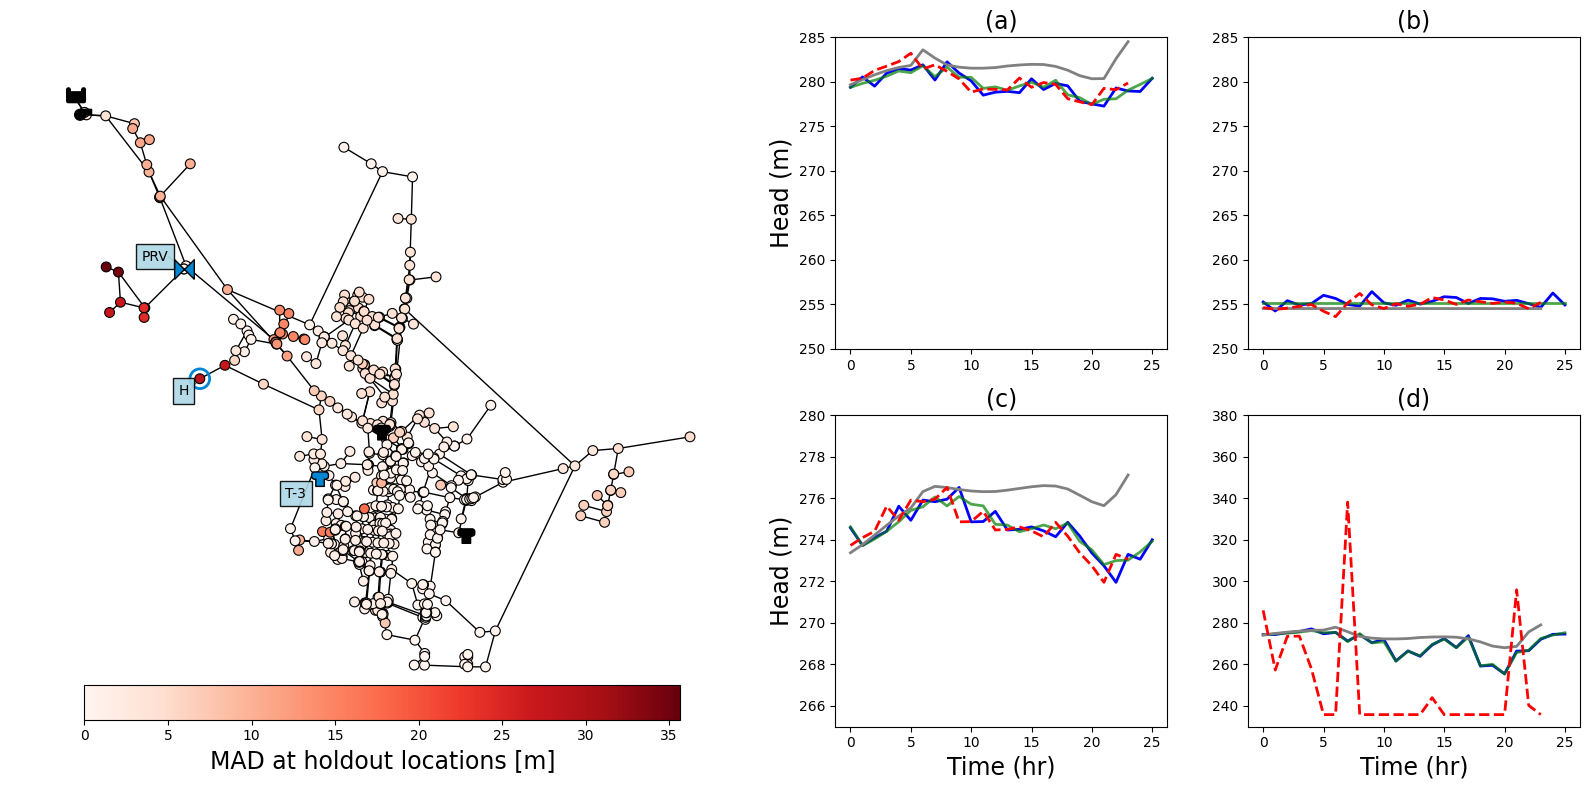

In [14]:
holdout_label = 'lightblue'
constrain_color = 'xkcd:cerulean'

model = vis.VisWNModel(inp_path)
xval = H_df_sensor['I-RV-1'].index / 3600

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)

fs = 17
node_size = 100

ax1 = plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=2, rowspan = 3)
  
ax1.set_frame_on(False) 
style = vis.NetworkStyle(cmap = 'Reds', vmin = 0, vmax = max_limit, draw_color_bar = False,  
                           draw_base_legend=False, tank_color=['k', 'k', 'xkcd:cerulean'], tank_size = 200, valve_size = 200, 
                         tank_border_width = 1, tank_border_color = 'k', 
                         valve_border_width = 1, valve_border_color = 'k', valve_color = constrain_color,
                         #node_size =  node_sizes, 
                         node_size = 200,
                         color_bar_width=0.8,
                         color_bar_height=0.03,
                         color_bar_loc='top',
                         color_bar_label_loc='top',
                         color_bar_label_font_size=14,
                         color_bar_label_font_color='k',
                        node_border_color =  'k', node_border_width = 0.8)

vis_model.plot_unique_data(ax=ax1, parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous',
                           color_bar_title = 'Mean average difference [%]',
                           style = style)

node_list = ['I-RV-1', 'O-RV-1', 'T-3', 'J-52']
names = ['PRV upstream node', 'PRV downstream node', 'Tank T-3', 'Node H']
names = ['(a)', '(b)', '(c)', '(d)']
names_2 = ['H1', 'H2', 'H3', 'H4']

model.draw_nodes(ax=ax1,  node_list =['J-52'],                
                 node_color = "None", node_size = 800, 
                 node_border_width = 2, node_border_color = constrain_color)


vis_model.draw_label(ax=ax1, draw_nodes=['T-3', 'J-52', 'I-RV-1'], 
                 labels=['T-3', 'H', 'PRV'], 
                 x_coords=[-600, -500, -700], y_coords=[-700, -500, 500], 
                 label_font_size = 10, label_face_color = holdout_label)
                 
# sensor nodes 
## valve start nodes
ax4 = plt.subplot2grid(shape=(2, 4), loc=(0, 2))
ax5 = plt.subplot2grid(shape=(2, 4), loc=(0, 3))
# valve end nodes
ax6 = plt.subplot2grid(shape=(2, 4), loc=(1, 2))
ax7 = plt.subplot2grid(shape=(2, 4), loc=(1, 3))

ax_list = [ax4, ax5, ax6, ax7]

    
for i, ax in enumerate(ax_list):
    #ax.plot(xval, measurements[node_list[i]].values, c='b', linewidth=2, label='Sensor reading')
    #ax.set_title(titles[i])
    #ax.plot(H_df_kf[node_list[i]].index / 3600, H_df_kf[node_list[i]].values,  c='r', linestyle = '--', linewidth=2, label='EKF')
    #ax.plot(H_df_model[node_list[i]].index / 3600, H_df_model[node_list[i]].values, c='gray',linewidth=2, label='Model')
    ax.plot(H_df_sensor[node_list[i]].index / 3600, H_df_sensor[node_list[i]].values, c='b', linewidth=2, label='Measurement')
    ax.plot(H_df_real[node_list[i]].index / 3600, H_df_real[node_list[i]].values, c='g', linewidth=2, label='Real', alpha = 0.7)
    ax.set_title(names[i], size=fs)    
    ax.plot(H_df_model[node_list[i]].index / 3600, H_df_model[node_list[i]].values, c='gray',linewidth=2, label='Model')
    ax.plot(H_df_filtered[node_list[i]].index / 3600, H_df_filtered[node_list[i]].values,  c='r', linestyle = '--', linewidth=2, label='EKF')
    #ax.set_ylim(y1, y2)

ax4.set_ylabel('Head (m)', size=fs)
ax6.set_ylabel('Head (m)', size=fs)
ax6.set_xlabel('Time (hr)', size=fs)
ax7.set_xlabel('Time (hr)', size=fs)

ax4.set_ylim(250, 285)
ax5.set_ylim(250, 285)
ax6.set_ylim(265,280)
ax7.set_ylim(230,380)

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax = inset_axes(ax1,
              height="5%", # set height
              width="80%", # and width
              loc=8) 
cmap = mpl.cm.Reds
norm = mpl.colors.Normalize(vmin=0, vmax=max(err))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('MAD at holdout locations [m]', fontsize=17)

plt.tight_layout()
plt.savefig('ky6_unconstrained_augmented_network.pdf', bbox_inches = 'tight')